# Prep and filter data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *
from ALLCools.mcds import MCDS
from pathlib import Path

In [2]:
import os
from pathlib import Path
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")
os.chdir(root_dir / "DMR_classifier")

In [3]:
meta_path = "allc_meta.tsv"
mcds_path = "DMR_CLS.mcds"
var_dim = "dmr_regions"
obs_dim = "cell"

In [4]:
metadata = pd.read_csv(meta_path, sep="\t", header=0, index_col=0)

In [5]:
metadata["celltype"].value_counts()

Oligo           13142
Astro            2485
Mono1            1796
Micro1           1388
SUB              1315
Micro2           1246
Tnaive_CD4_1     1134
OPC              1118
Marc_HT           755
Marc_Nrv          740
Mac_Alv           567
NK_CD16_Bld       458
Mono2             385
Tnaive_CD4_2      364
Fibro_Mus         344
DG                311
VIP               306
Endo-VLMC         246
Tnaive_CD8_1      221
Tnaive_CD8_2      196
SST               195
PVALB             180
NR2F2-LAMP5       176
infant_MGC-1      174
Mast_Skn          160
CA                132
NK_CD56_Bld       121
Mono_HT           120
Endo_Lym_Skn      116
NK_CK56_Skn       105
Name: celltype, dtype: int64

In [6]:
mcds = MCDS.open(mcds_path, obs_dim=obs_dim, var_dim=var_dim)

In [7]:
mcds.add_cell_metadata(metadata)

In [8]:
mcds

<xarray.MCDS>
Dimensions:                        (cell: 29996, count_type: 2,
                                    dmr_regions: 601220, mc_type: 2)
Coordinates:
  * cell                           (cell) object 'hc1153-1-2-D12-AD002' ... '...
  * count_type                     (count_type) <U3 'mc' 'cov'
  * dmr_regions                    (dmr_regions) <U17 'Union_DMR_3' ... 'Unio...
    dmr_regions_chrom              (dmr_regions) <U5 'chr1' 'chr1' ... 'chr22'
    dmr_regions_end                (dmr_regions) int64 795102 ... 50785571
    dmr_regions_start              (dmr_regions) int64 794991 ... 50785180
  * mc_type                        (mc_type) <U3 'CHN' 'CGN'
    cell_allc_path                 (cell) object '/tscc/projects/ps-epigen/us...
    cell_celltype                  (cell) object 'Oligo' ... 'infant_MGC-1'
Data variables:
    dmr_regions_da                 (cell, dmr_regions, mc_type, count_type) uint32 dask.array<chunksize=(7, 75153, 1, 1), meta=np.ndarray>
    dmr_regions_da_CGN-hypo-score  (cell, dmr_regions) float16 dask.array<chunksize=(7, 75153), meta=np.ndarray>
    dmr_regions_da_CHN-hypo-score  (cell, dmr_regions) float16 dask.array<chunksize=(7, 75153), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  dmr_regions

## Some check

In [9]:
## Blacklist regions and Sex chromosomes already removed

In [10]:
import xarray as xr

In [11]:
# First plot the total read counts for each cell grouped by cell type
sel_da = mcds["dmr_regions_da"].sel(mc_type="CGN", count_type="cov")
total_cov_per_cell = sel_da.sum(dim="dmr_regions").to_pandas()
total_cov_per_cell.name = "total_cov"

In [12]:
total_cov_per_cell

cell
hc1153-1-2-D12-AD002                            72792
hc1153-1-2-D12-AD012                            78094
hc1153-1-2-D12-AD010                            79141
hc1153-1-2-D12-AD006                            76577
hc1153-1-2-D12-AD004                            73191
                                                ...  
allc_210830-UA19-27-HPC-1-B07_H22_indexed      206418
allc_20211029-UA19-27-HPC-2-A11_K18_indexed    716261
allc_210830-UA19-27-HPC-1-B07_E22_indexed      150175
allc_20211130-UA19-27-HPC-8-B08_N1_indexed     122640
allc_20211029-UA19-27-HPC-3-A10_O11_indexed    324434
Name: total_cov, Length: 29996, dtype: uint64

In [13]:
metadata = metadata.join(total_cov_per_cell)
metadata.to_csv("allc_meta.tsv", sep="\t", header=True, index=True)

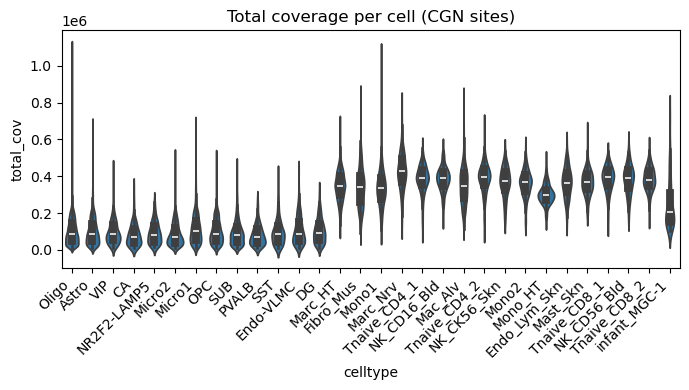

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.violinplot(data=metadata, x="celltype", y="total_cov", inner="box")
plt.xticks(rotation=45, ha="right")
plt.title("Total coverage per cell (CGN sites)")
plt.tight_layout()
plt.show()

In [15]:
dmr_start = mcds["dmr_regions_start"].values
dmr_end = mcds["dmr_regions_end"].values
dmr_names = mcds["dmr_regions"].values
dmr_df = pd.DataFrame({
    "start": dmr_start,
    "end": dmr_end,
}, index=dmr_names)
dmr_df["length"] = dmr_df["end"] - dmr_df["start"]

In [16]:
dmr_mean_cov = sel_da.mean(dim=obs_dim).to_pandas()
dmr_df["mean_cov"] = dmr_mean_cov

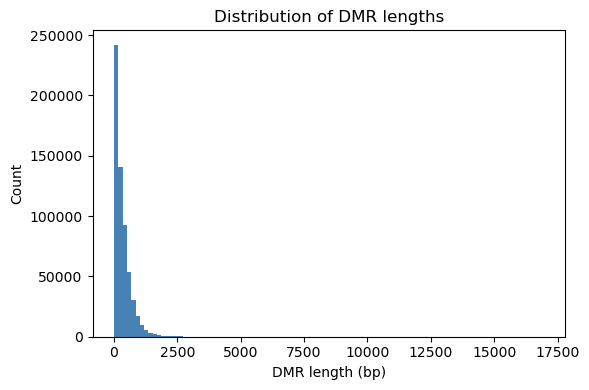

In [17]:
plt.figure(figsize=(6, 4))
plt.hist(dmr_df["length"], bins=100, color="steelblue", edgecolor=None)
plt.xlabel("DMR length (bp)")
plt.ylabel("Count")
plt.title("Distribution of DMR lengths")
plt.tight_layout()
plt.show()

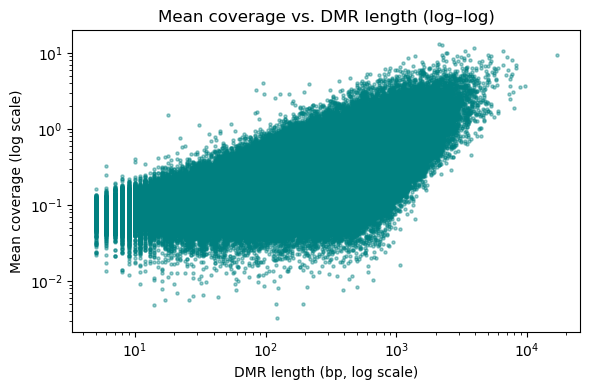

In [18]:
plt.figure(figsize=(6, 4))
plt.scatter(dmr_df["length"], dmr_df["mean_cov"], s=5, alpha=0.4, color="teal")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("DMR length (bp, log scale)")
plt.ylabel("Mean coverage (log scale)")
plt.title("Mean coverage vs. DMR length (log–log)")
plt.tight_layout()
plt.show()

# Downsample cell types to at most 500

In [9]:
nsample = 500
meta_sub = (
    metadata.groupby("celltype", group_keys=False).
        apply(lambda x: x.sample(n=min(len(x), nsample), random_state=42))
)
meta_sub = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=0, index_col=0)

In [10]:
meta_sub["celltype"].value_counts()

Astro           500
Micro2          500
Tnaive_CD4_1    500
SUB             500
Oligo           500
OPC             500
Mac_Alv         500
Marc_HT         500
Marc_Nrv        500
Mono1           500
Micro1          500
NK_CD16_Bld     458
Mono2           385
Tnaive_CD4_2    364
Fibro_Mus       344
DG              311
VIP             306
Endo-VLMC       246
Tnaive_CD8_1    221
Tnaive_CD8_2    196
SST             195
PVALB           180
NR2F2-LAMP5     176
infant_MGC-1    174
Mast_Skn        160
CA              132
NK_CD56_Bld     121
Mono_HT         120
Endo_Lym_Skn    116
NK_CK56_Skn     105
Name: celltype, dtype: int64

In [11]:
mcds = mcds.sel({obs_dim: meta_sub.index})

In [12]:
mcds

<xarray.MCDS>
Dimensions:                        (cell: 9810, count_type: 2,
                                    dmr_regions: 601220, mc_type: 2)
Coordinates:
  * cell                           (cell) object 'm5551-1-2-H7-AD012' ... 'al...
  * count_type                     (count_type) <U3 'mc' 'cov'
  * dmr_regions                    (dmr_regions) <U17 'Union_DMR_3' ... 'Unio...
    dmr_regions_chrom              (dmr_regions) <U5 'chr1' 'chr1' ... 'chr22'
    dmr_regions_end                (dmr_regions) int64 795102 ... 50785571
    dmr_regions_start              (dmr_regions) int64 794991 ... 50785180
  * mc_type                        (mc_type) <U3 'CHN' 'CGN'
    cell_allc_path                 (cell) object '/tscc/projects/ps-epigen/us...
    cell_celltype                  (cell) object 'Astro' ... 'infant_MGC-1'
Data variables:
    dmr_regions_da                 (cell, dmr_regions, mc_type, count_type) uint32 dask.array<chunksize=(1, 75153, 1, 1), meta=np.ndarray>
    dmr_regions_da_CGN-hypo-score  (cell, dmr_regions) float16 dask.array<chunksize=(1, 75153), meta=np.ndarray>
    dmr_regions_da_CHN-hypo-score  (cell, dmr_regions) float16 dask.array<chunksize=(1, 75153), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  dmr_regions

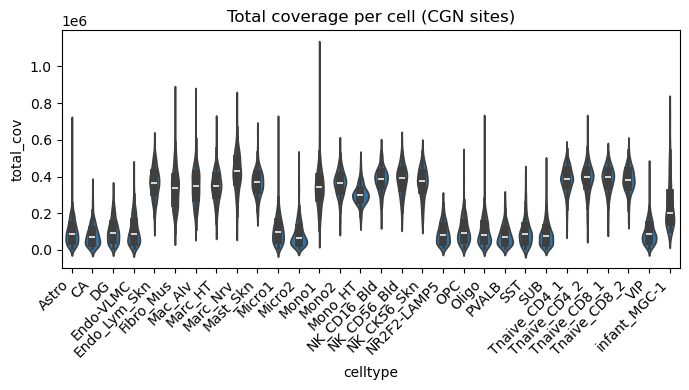

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.violinplot(data=meta_sub, x="celltype", y="total_cov", inner="box")
plt.xticks(rotation=45, ha="right")
plt.title("Total coverage per cell (CGN sites)")
plt.tight_layout()
plt.show()

In [14]:
mcad = mcds.get_score_adata(mc_type="CGN", quant_type="hypo-score")

Loading chunk 0-9810/9810


/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [15]:
mcad.write_h5ad("dmr_regions-CGN_hypo_score.h5ad")

In [16]:
meta_sub.to_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=True, index=True)

In [17]:
# Raw frac
da = mcds["dmr_regions_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
beta = mc / cov
beta = beta.where(~np.isnan(beta), 0.5)
beta = beta.clip(0, 1)

In [18]:
import xarray as xr
beta_cat = xr.full_like(beta, 0)
beta_cat = xr.where(beta > 0.5, 1, beta_cat)
beta_cat = xr.where(beta < 0.5, -1, beta_cat)
has_1 = (beta_cat == 1).any(dim="cell")
has_neg1 = (beta_cat == -1).any(dim="cell")
selected_regions = has_1 & has_neg1

In [19]:
beta_cat

<xarray.DataArray 'dmr_regions_da' (cell: 9810, dmr_regions: 601220)>
dask.array<where, shape=(9810, 601220), dtype=float64, chunksize=(2, 75153), chunktype=numpy.ndarray>
Coordinates:
  * cell               (cell) object 'm5551-1-2-H7-AD012' ... 'allc_20211130-...
  * dmr_regions        (dmr_regions) <U17 'Union_DMR_3' ... 'Union_DMR_2977722'
    dmr_regions_chrom  (dmr_regions) <U5 'chr1' 'chr1' ... 'chr22' 'chr22'
    dmr_regions_end    (dmr_regions) int64 795102 813166 ... 50782046 50785571
    dmr_regions_start  (dmr_regions) int64 794991 813081 ... 50781948 50785180
    mc_type            <U3 'CGN'
    cell_allc_path     (cell) object '/tscc/projects/ps-epigen/users/biy022/s...
    cell_celltype      (cell) object 'Astro' 'Astro' ... 'infant_MGC-1'

In [20]:
from scipy import sparse
beta_cat_filtered = beta_cat.sel(dmr_regions=selected_regions)
beta_cat_filtered = beta_cat_filtered.transpose("cell", "dmr_regions")
X_sparse = sparse.csr_matrix(beta_cat_filtered.values)

In [21]:
adata = anndata.AnnData(
    X=X_sparse,
    obs=pd.DataFrame(index=beta_cat_filtered.coords["cell"].values),
    var=pd.DataFrame(index=beta_cat_filtered.coords["dmr_regions"].values),
)

In [22]:
adata

AnnData object with n_obs × n_vars = 9810 × 600965

In [23]:
adata.X[0:10, 0:10].todense()

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [24]:
adata.obs["celltype"] = meta_sub.loc[adata.obs_names, "celltype"].copy()

In [25]:
adata.write_h5ad("dmr_regions-CGN_beta_trinarized.h5ad")

### Subset all micro1 and micro2 for test trinarization

In [9]:
micro_meta = metadata[metadata["celltype"].isin(["Micro1", "Micro2"])]

In [10]:
mcds = mcds.sel({obs_dim: micro_meta.index})

In [11]:
# Raw frac
da = mcds["dmr_regions_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
beta = mc / cov
beta = beta.where(~np.isnan(beta), 0.5)
beta = beta.clip(0, 1)

In [12]:
import xarray as xr
beta_cat = xr.full_like(beta, 0)
beta_cat = xr.where(beta > 0.5, 1, beta_cat)
beta_cat = xr.where(beta < 0.5, -1, beta_cat)

In [13]:
tri_ds_adata = sc.read_h5ad("dmr_regions-CGN_beta_trinarized.h5ad")
selected_regions = tri_ds_adata.var_names

In [14]:
len(selected_regions)

600965

In [15]:
from scipy import sparse
beta_cat_filtered = beta_cat.sel(dmr_regions=selected_regions)
beta_cat_filtered = beta_cat_filtered.transpose("cell", "dmr_regions")
X_sparse = sparse.csr_matrix(beta_cat_filtered.values)

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [16]:
adata = anndata.AnnData(
    X=X_sparse,
    obs=pd.DataFrame(index=beta_cat_filtered.coords["cell"].values),
    var=pd.DataFrame(index=beta_cat_filtered.coords["dmr_regions"].values),
)

In [17]:
adata

AnnData object with n_obs × n_vars = 2634 × 600965

In [18]:
adata.obs["celltype"] = metadata.loc[adata.obs_names, "celltype"].copy()

In [19]:
adata.obs["celltype"].unique()

array(['Micro2', 'Micro1'], dtype=object)

In [20]:
adata.write_h5ad("dmr_regions-CGN_beta_trinarized-Micro_subtypes_test.h5ad")

# Downsample at most 200: need to account for GPU memory

In [9]:
mcds.add_mc_frac(var_dim=var_dim, normalize_per_cell=False)

In [10]:
nsample = 150
meta_sub = (
    metadata.groupby("celltype", group_keys=False).
        apply(lambda x: x.sample(n=min(len(x), nsample), random_state=42))
)

In [11]:
mcds = mcds.sel({obs_dim: meta_sub.index})

In [12]:
adata = mcds.get_adata(mc_type="CGN", obs_dim=obs_dim, var_dim=var_dim, select_hvf=False)

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [13]:
adata

AnnData object with n_obs × n_vars = 4344 × 601220
    obs: 'allc_path', 'celltype'
    var: 'chrom', 'end', 'start'

In [14]:
adata.write_h5ad("dmr_regions-CGN_posterior_frac.h5ad")

In [15]:
meta_sub.to_csv("dmr_regions-CGN_hypo_score-meta_sub_200.tsv", sep="\t", header=True, index=True)